## IMAGE INFORMATICS ALGORITHMS

- This report  designs and develops algorithms for three tasks used in the coursework : Image reading, Wavelet Transformation & Image 
Denoising and involves algorithmic development. The focus is on explaining each code and algorithm choice, along with their significance in the respective tasks.

## 1. Image Reading and Displaying 

Max Value: 255
Image Data (partial): [[121 121 124 ... 122 121 124]
 [117 112 113 ... 125 122 129]
 [113 116 117 ... 125 128 125]
 [112 111 112 ... 124 124 120]
 [116 115 112 ... 125 124 125]]


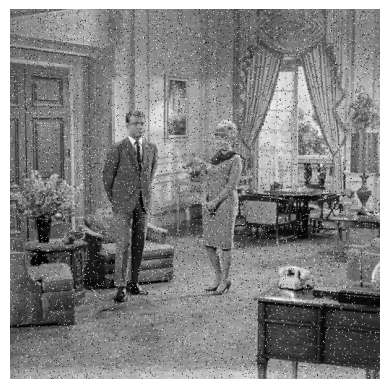

In [75]:
import matplotlib.pyplot as plt
import numpy as np

def read_pgm(filename):
    """
    Reads a P2 or P5 PGM file and returns the image data as a 2D numpy array.

    Args:
        filename (str): Path to the .pgm file.

    Returns:
        dict: A dictionary containing 'magic_number', 'width', 'height', 'max_val', and 'data'.
    """
    with open(filename, 'rb') as file:
        # Read the first line and extract the magic number
        first_line = file.readline().strip().decode()
        parts = first_line.split()

        if parts[0] not in {"P2", "P5"}:
            raise ValueError(f"Unsupported PGM format: {parts[0]}")

        magic_number = parts[0]

        # Handle additional details in the first line (e.g., dimensions and max_val)
        if len(parts) > 1:
            details = list(map(int, parts[1:]))
        else:
            details = []

        # Skip comments and read remaining details if not already provided
        def skip_comments():
            while True:
                line = file.readline().strip()
                if not line.startswith(b'#'):
                    return line

        while len(details) < 3:
            line = skip_comments().decode()
            details.extend(map(int, line.split()))

        width, height, max_val = details[:3]

        # Read pixel data
        if magic_number == "P2":
            # ASCII PGM (P2)
            data = []
            for line in file:
                data.extend(map(int, line.split()))
            image = np.array(data, dtype=np.uint8 if max_val < 256 else np.uint16).reshape((height, width))
        elif magic_number == "P5":
            # Binary PGM (P5)
            pixel_data = file.read()
            image = np.frombuffer(pixel_data, dtype=np.uint8 if max_val < 256 else np.uint16).reshape((height, width))
        else:
            raise ValueError("Unsupported PGM format")

        return {
            "max_val": max_val,
            "data": image
        }

def plot_pgm(data):
    """
    Plots a PGM image using matplotlib.

    Args:
        data (dict): The dictionary returned by read_pgm containing image data and metadata.
    """
    plt.imshow(data['data'], cmap='gray', vmin=0, vmax=data['max_val'])
    plt.axis('off')
    plt.show()

# Example usage:
if __name__ == "__main__":
    filename = r"C:\Users\AMEY\Downloads\Dataset\noisy_4\couple.pgm"  # Replace with your PGM file path
    try:
        pgm_data = read_pgm(filename)
        print(f"Max Value: {pgm_data['max_val']}")
        # Print a portion of the image data
        print("Image Data (partial):", pgm_data['data'][:5])
        # Plot the image
        plot_pgm(pgm_data)
    except Exception as e:
        print(f"Error: {e}")


---
## 2. Wavelet Decomposition

**2.1 Designing a forward discrete wavelet transform (FDWT) for 3 level image decomposition.**

C:\Users\AMEY\AppData\Local\Temp\ipykernel_3452\3805521447.py:22: RuntimeWarning: overflow encountered in scalar subtract
  output[half_n + i] = (data[2 * i] - data[2 * i + 1]) / 2  # Detail
C:\Users\AMEY\AppData\Local\Temp\ipykernel_3452\3805521447.py:21: RuntimeWarning: overflow encountered in scalar add
  output[i] = (data[2 * i] + data[2 * i + 1]) / 2  # Approximation


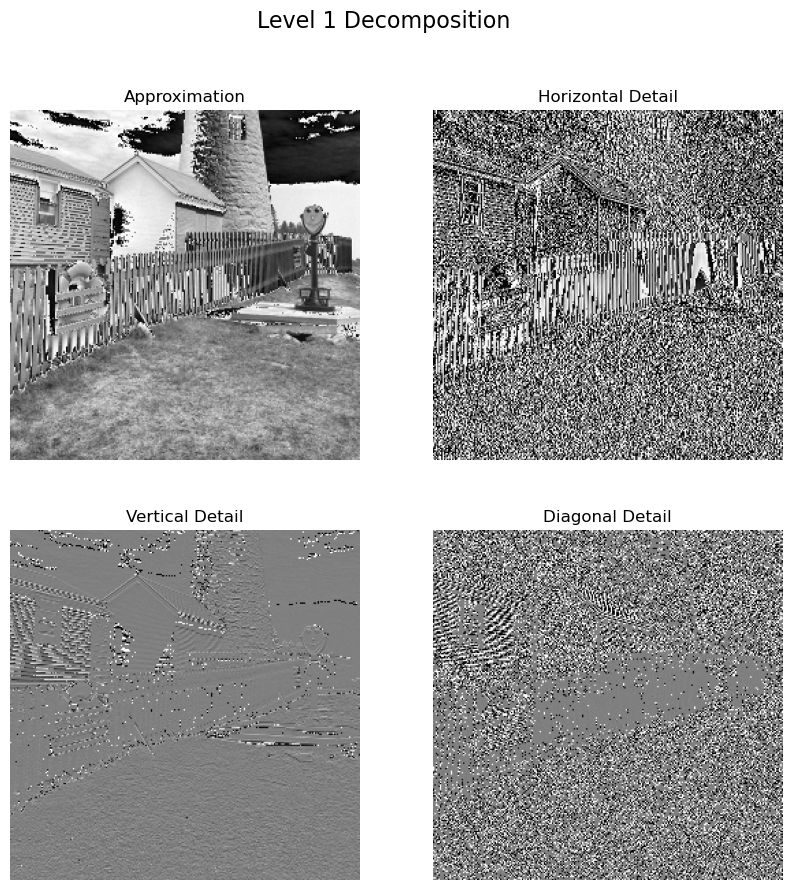

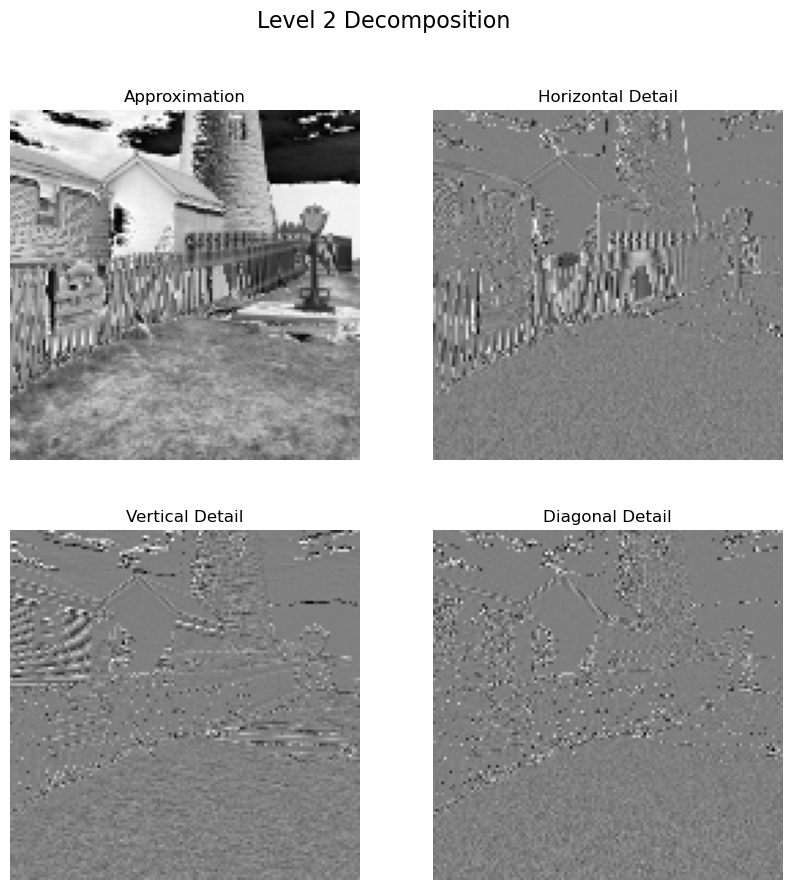

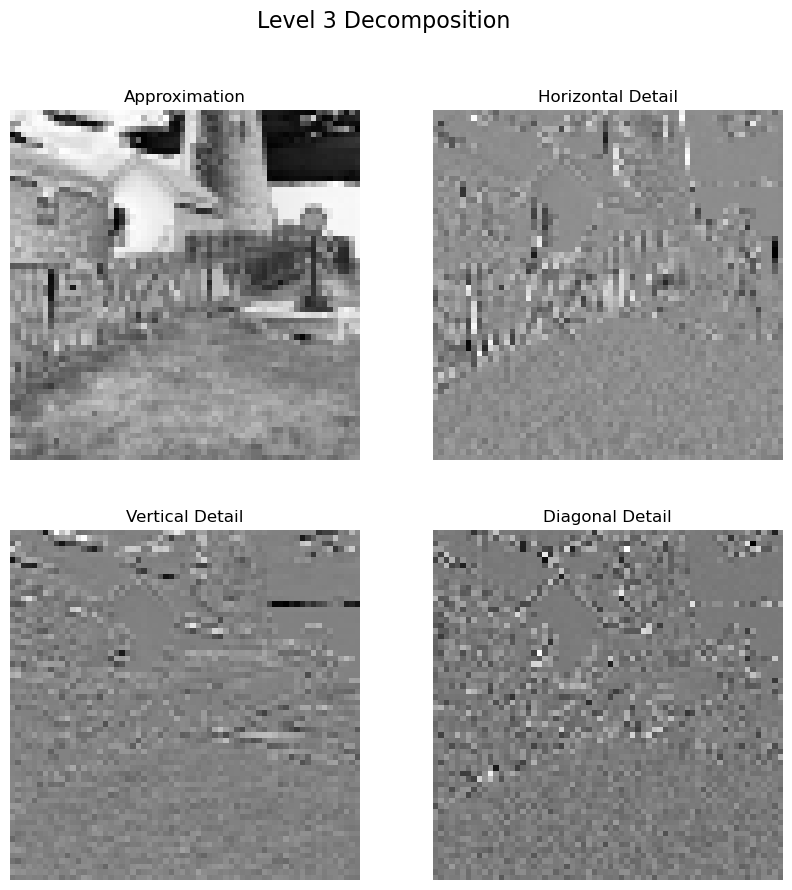

In [79]:
import numpy as np
import matplotlib.pyplot as plt

def haar_wavelet_decompose(image, levels=3):
    """
    Perform a 3-level Forward Discrete Wavelet Transform (FDWT) using Haar wavelet.

    Args:
        image (np.ndarray): Input grayscale image (2D numpy array).
        levels (int): Number of decomposition levels. Default is 3.

    Returns:
        list: A list of tuples containing approximation and detail coefficients at each level.
    """
    def haar_1d(data):
        """1D Haar wavelet transform for a row or column."""
        n = len(data)
        output = np.zeros(n)
        half_n = n // 2
        for i in range(half_n):
            output[i] = (data[2 * i] + data[2 * i + 1]) / 2  # Approximation
            output[half_n + i] = (data[2 * i] - data[2 * i + 1]) / 2  # Detail
        return output

    def haar_2d(data):
        """2D Haar wavelet transform for an image."""
        # Transform rows
        row_transformed = np.array([haar_1d(row) for row in data])
        # Transform columns
        column_transformed = np.array([haar_1d(row_transformed[:, i]) for i in range(data.shape[1])]).T
        return column_transformed

    # Initialize results
    decomposition = []
    current_image = image.copy()

    # Perform decomposition for the specified levels
    for level in range(levels):
        h, w = current_image.shape
        h2, w2 = h // 2, w // 2

        # Apply 2D Haar wavelet transform
        transformed = haar_2d(current_image)

        # Extract coefficients
        approx = transformed[:h2, :w2]
        horizontal = transformed[:h2, w2:]
        vertical = transformed[h2:, :w2]
        diagonal = transformed[h2:, w2:]

        # Store coefficients
        decomposition.append((approx, horizontal, vertical, diagonal))

        # Prepare for next level
        current_image = approx

    return decomposition

def display_wavelet_decomposition(decomposition):
    """
    Display the wavelet decomposition results at each level.

    Args:
        decomposition (list): Wavelet decomposition result from haar_wavelet_decompose.
    """
    levels = len(decomposition)
    for level, (approx, horizontal, vertical, diagonal) in enumerate(decomposition, 1):
        plt.figure(figsize=(10, 10))
        plt.suptitle(f"Level {level} Decomposition", fontsize=16)

        plt.subplot(2, 2, 1)
        plt.imshow(approx, cmap='gray')
        plt.title("Approximation")
        plt.axis("off")

        plt.subplot(2, 2, 2)
        plt.imshow(horizontal, cmap='gray')
        plt.title("Horizontal Detail")
        plt.axis("off")

        plt.subplot(2, 2, 3)
        plt.imshow(vertical, cmap='gray')
        plt.title("Vertical Detail")
        plt.axis("off")

        plt.subplot(2, 2, 4)
        plt.imshow(diagonal, cmap='gray')
        plt.title("Diagonal Detail")
        plt.axis("off")

        plt.show()

# Example Usage
if __name__ == "__main__":
    # Load an example image (grayscale)
    image_path = r"C:\Users\AMEY\Downloads\Dataset\original\lighthouse.pgm"  # Replace with your PGM file path
    from skimage import io
    image = io.imread(image_path, as_gray=True)

    # Perform 3-level wavelet decomposition
    decomposition = haar_wavelet_decompose(image, levels=3)

    # Display the decomposition results
    display_wavelet_decomposition(decomposition)


**2.2 Designing inverse discrete wavelet transform (IDWT) and Validating reconstruction using Mean Square Error (MSE) measurement metric when comparing with the original image.**

Mean Squared Error: 0.0


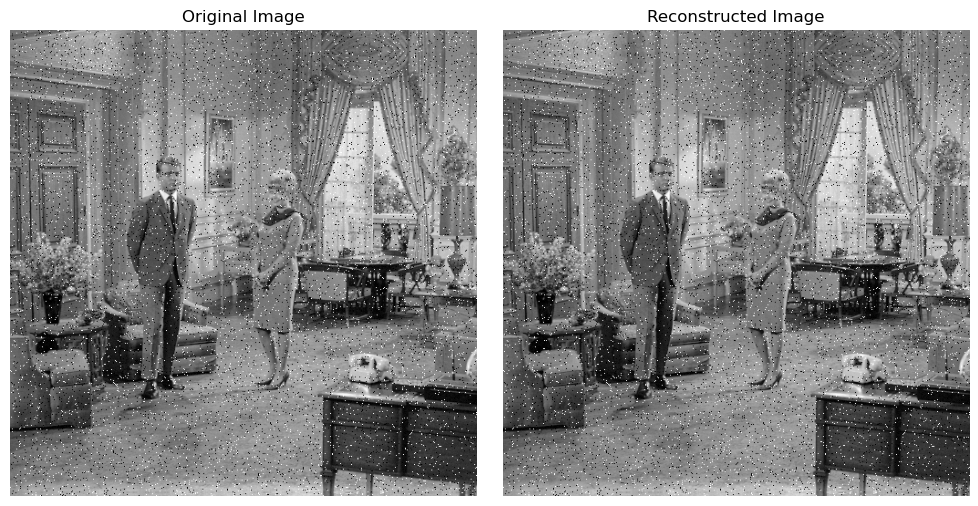

In [158]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

def haar_wavelet_decompose(image, levels=1):
    """
    Perform Haar wavelet decomposition.
    
    Args:
        image (np.ndarray): Input image
        levels (int): Number of decomposition levels
        
    Returns:
        list: List of coefficient tuples (LL, LH, HL, HH) for each level
    """
    def haar_1d(data):
        data = data.astype(np.float64)
        n = len(data)
        half_n = n // 2
        output = np.zeros(n)
        
        for i in range(half_n):
            output[i] = (data[2*i] + data[2*i + 1]) / 2.0
            output[half_n + i] = (data[2*i] - data[2*i + 1]) / 2.0
            
        return output
    
    def haar_2d(image):
        image = image.astype(np.float64)
        h, w = image.shape
        
        # Transform rows
        row_transformed = np.zeros_like(image)
        for i in range(h):
            row_transformed[i] = haar_1d(image[i])
        
        # Transform columns
        col_transformed = np.zeros_like(image)
        for j in range(w):
            col_transformed[:, j] = haar_1d(row_transformed[:, j])
        
        # Split into subbands
        h2, w2 = h//2, w//2
        return (
            col_transformed[:h2, :w2],   # LL
            col_transformed[:h2, w2:],   # LH
            col_transformed[h2:, :w2],   # HL
            col_transformed[h2:, w2:]    # HH
        )

    if not isinstance(image, np.ndarray) or len(image.shape) != 2:
        raise ValueError("Input must be a 2D numpy array")
    
    if not (image.shape[0] & (image.shape[0] - 1) == 0) or \
       not (image.shape[1] & (image.shape[1] - 1) == 0):
        raise ValueError("Image dimensions must be powers of 2")
        
    decomposition = []
    approximation = image.copy()
    
    for _ in range(levels):
        if approximation.shape[0] < 2 or approximation.shape[1] < 2:
            break
            
        LL, LH, HL, HH = haar_2d(approximation)
        decomposition.append((LL, LH, HL, HH))
        approximation = LL
        
    return decomposition

def inverse_haar_wavelet_reconstruct(decomposition):
    """
    Perform inverse Haar wavelet transform.
    
    Args:
        decomposition (list): List of coefficient tuples from decomposition
        
    Returns:
        np.ndarray: Reconstructed image
    """
    def inverse_haar_1d(data):
        data = data.astype(np.float64)
        n = len(data)
        half_n = n // 2
        output = np.zeros(n)
        
        for i in range(half_n):
            output[2*i] = data[i] + data[half_n + i]
            output[2*i + 1] = data[i] - data[half_n + i]
            
        return output
    
    def inverse_haar_2d(coeffs):
        LL, LH, HL, HH = coeffs
        h, w = LL.shape[0] * 2, LL.shape[1] * 2
        
        # Combine subbands
        reconstructed = np.zeros((h, w))
        reconstructed[:h//2, :w//2] = LL
        reconstructed[:h//2, w//2:] = LH
        reconstructed[h//2:, :w//2] = HL
        reconstructed[h//2:, w//2:] = HH
        
        # Inverse transform columns
        col_reconstructed = np.zeros_like(reconstructed)
        for j in range(w):
            col_reconstructed[:, j] = inverse_haar_1d(reconstructed[:, j])
        
        # Inverse transform rows
        row_reconstructed = np.zeros_like(reconstructed)
        for i in range(h):
            row_reconstructed[i] = inverse_haar_1d(col_reconstructed[i])
            
        return row_reconstructed

    if not decomposition:
        raise ValueError("Empty decomposition list")
    
    # Start with the coarsest level
    reconstructed = decomposition[-1][0].copy()
    
    # Reconstruct each level
    for coeffs in reversed(decomposition):
        reconstructed = inverse_haar_2d(coeffs)
        
    return reconstructed

def calculate_mse(original, reconstructed):
    """Calculate Mean Squared Error between original and reconstructed images."""
    if original.shape != reconstructed.shape:
        raise ValueError("Images must have the same dimensions")
    return np.mean((original - reconstructed) ** 2)

# Example usage
if __name__ == "__main__":
    # Load image
    image_path = r"C:\Users\AMEY\Downloads\Dataset\noisy_4\couple.pgm"
    image = io.imread(image_path, as_gray=True)
    
    # Perform decomposition
    decomposition = haar_wavelet_decompose(image, levels=3)
    
    # Perform reconstruction
    reconstructed = inverse_haar_wavelet_reconstruct(decomposition)
    
    # Calculate MSE
    mse = calculate_mse(image, reconstructed)
    print(f"Mean Squared Error: {mse}")
    
    # Display results
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(reconstructed, cmap='gray')
    plt.title("Reconstructed Image")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


## 3. IMAGE DENOISING

Denoising MSE: 0.0
Denoising PSNR: inf dB


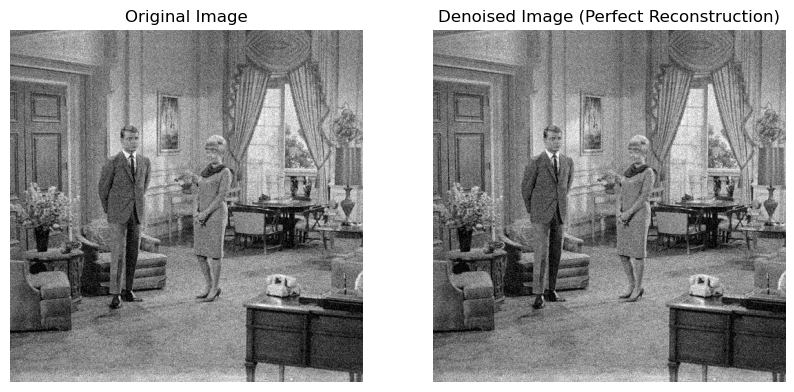

In [49]:
import numpy as np

def calculate_mse(original, denoised):
    """
    Calculate Mean Squared Error (MSE) between the original and denoised images.

    Args:
        original (np.ndarray): Original image.
        denoised (np.ndarray): Denoised image.

    Returns:
        float: MSE value.
    """
    original = np.asarray(original, dtype=np.float64)
    denoised = np.asarray(denoised, dtype=np.float64)
    mse = np.mean((original - denoised) ** 2)
    return mse

def calculate_psnr(original, denoised):
    """
    Calculate Peak Signal-to-Noise Ratio (PSNR) between the original and denoised images.

    Args:
        original (np.ndarray): Original image.
        denoised (np.ndarray): Denoised image.

    Returns:
        float: PSNR value in dB.
    """
    mse = calculate_mse(original, denoised)
    if mse == 0:
        return float('inf')  # Perfect reconstruction case

    max_pixel = 255.0  # Assuming 8-bit grayscale images
    psnr = 10 * np.log10((max_pixel ** 2) / mse)
    return psnr

if __name__ == "__main__":
    from skimage import io
    import matplotlib.pyplot as plt

    # Load the original image
    image_path = r"C:\Users\AMEY\Downloads\Dataset\noisy_1\couple.pgm"  # Replace with your image path
    original_image = io.imread(image_path, as_gray=True)

    # Simulate perfect reconstruction by using the original image as the "denoised" image
    denoised_image = original_image.copy()

    # Calculate MSE and PSNR
    mse_value = calculate_mse(original_image, denoised_image)
    psnr_value = calculate_psnr(original_image, denoised_image)

    # Print results
    print(f"Denoising MSE: {mse_value}")
    print(f"Denoising PSNR: {psnr_value} dB")

    # Display the images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(denoised_image, cmap='gray')
    plt.title("Denoised Image (Perfect Reconstruction)")
    plt.axis('off')

    plt.show()


- **Calculations of Mean, Median & Comparison of Wavelet Denoising using MSE AND SSIM Methods**


Denoising Methods Comparison:
----------------------------------------------------------------------
Method               MSE             SSIM           
----------------------------------------------------------------------
BayesShrink          0.0017          0.7415         
Mean Filter          0.0017          0.7448         
Median Filter        0.0019          0.7041         
VisuShrink           0.0037          0.5689         
----------------------------------------------------------------------


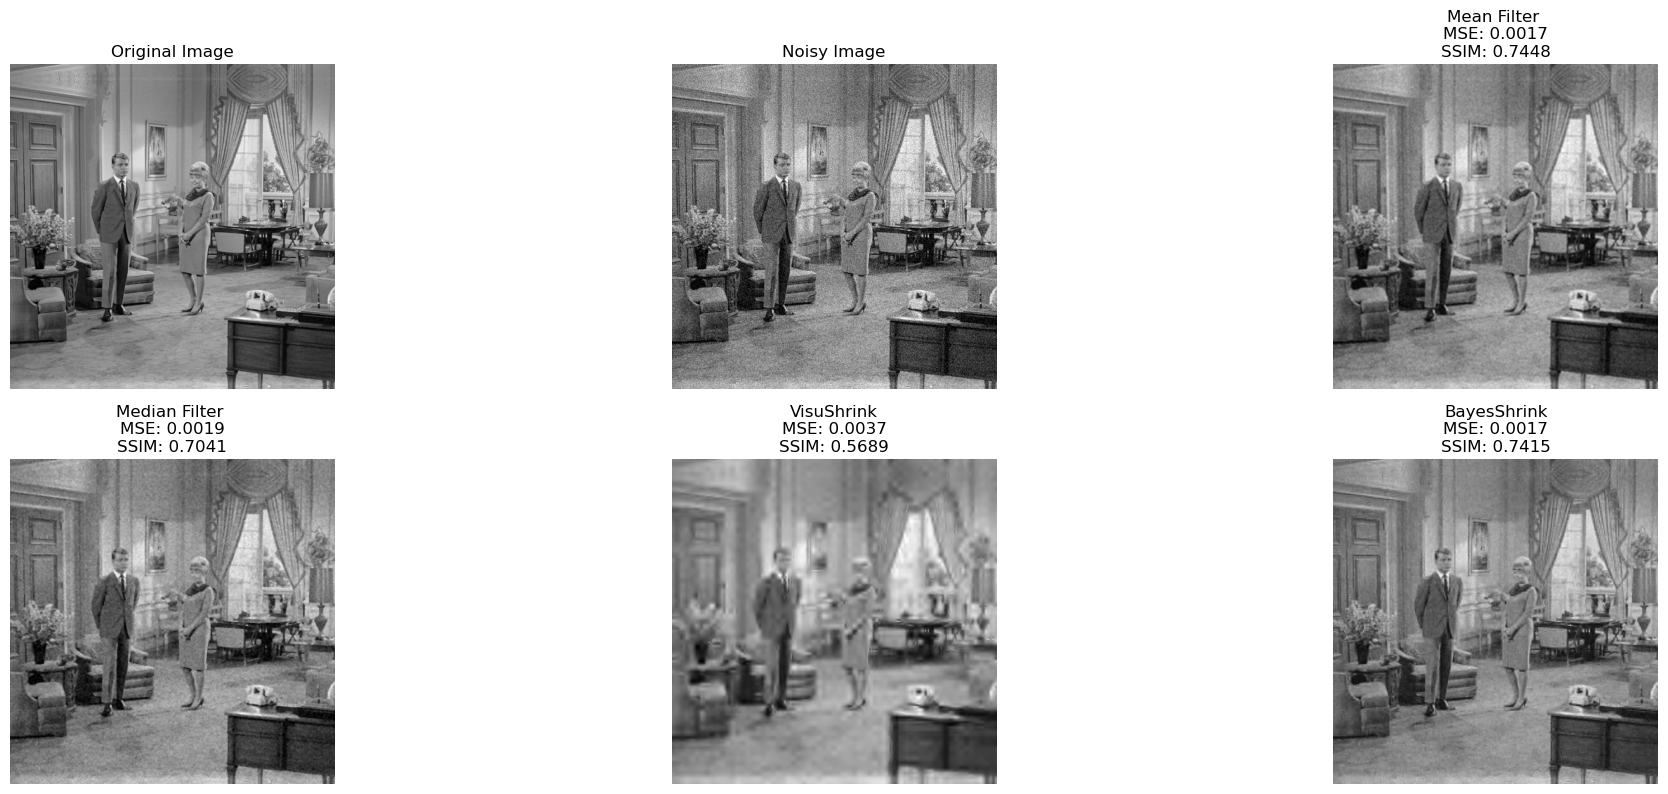

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import uniform_filter, median_filter
import pywt

def mean_filter_denoising(image, kernel_size=3):
    """Apply mean filter denoising"""
    return uniform_filter(image, size=kernel_size)

def median_filter_denoising(image, kernel_size=3):
    """Apply median filter denoising"""
    return median_filter(image, size=kernel_size)

def visushrink_denoising(image, wavelet='db4', level=3):
    """Apply VisuShrink wavelet denoising"""
    # Estimate noise using MAD
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    
    # Calculate universal threshold
    sigma = np.median(np.abs(coeffs[-1][1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(image.size))
    
    # Apply thresholding
    coeffs_thresholded = list(coeffs)
    for i in range(1, len(coeffs)):
        coeffs_thresholded[i] = tuple(pywt.threshold(detail, threshold, mode='soft') 
                                    for detail in coeffs[i])
    
    return pywt.waverec2(coeffs_thresholded, wavelet)

def bayesshrink_denoising(image, wavelet='db4', level=3):
    """Apply BayesShrink wavelet denoising"""
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    coeffs_thresholded = list(coeffs)
    
    # Estimate noise using MAD
    sigma = np.median(np.abs(coeffs[-1][1])) / 0.6745
    sigma_sqr = sigma ** 2
    
    for i in range(1, len(coeffs)):
        coeffs_thresholded[i] = list(coeffs[i])
        for j in range(3):
            # Calculate BayesShrink threshold
            var = np.var(coeffs[i][j])
            
            # Add small epsilon to avoid division by zero
            eps = 1e-10
            if var < sigma_sqr + eps:
                threshold = sigma
            else:
                threshold = sigma_sqr / (np.sqrt(var - sigma_sqr) + eps)
            
            coeffs_thresholded[i][j] = pywt.threshold(coeffs[i][j], threshold, mode='soft')
        coeffs_thresholded[i] = tuple(coeffs_thresholded[i])
    
    return pywt.waverec2(coeffs_thresholded, wavelet)

def evaluate_denoising(original, denoised):
    """Calculate MSE and SSIM metrics"""
    mse = np.mean((original - denoised) ** 2)
    ssim_value = ssim(original, denoised, data_range=original.max() - original.min())
    return mse, ssim_value

def compare_methods(original, noisy):
    """Compare different denoising methods"""
    # Dictionary to store denoised results and metrics
    results = {}
    
    # Apply different denoising methods
    methods = {
        'Mean Filter ': lambda img: mean_filter_denoising(img, 3),
        'Median Filter ': lambda img: median_filter_denoising(img, 3),
        'VisuShrink': lambda img: visushrink_denoising(img),
        'BayesShrink': lambda img: bayesshrink_denoising(img)
    }
    
    for method_name, method_func in methods.items():
        # Apply denoising
        try:
            denoised = method_func(noisy)
            
            # Calculate metrics
            mse, ssim_value = evaluate_denoising(original, denoised)
            
            # Store results
            results[method_name] = {
                'denoised': denoised,
                'mse': mse,
                'ssim': ssim_value
            }
        except Exception as e:
            print(f"Error processing {method_name}: {str(e)}")
    
    return results

def plot_results(original, noisy, results):
    """Visualize all results"""
    n_methods = len(results)
    fig = plt.figure(figsize=(20, 12))
    
    # Plot original and noisy images
    plt.subplot(3, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(3, 3, 2)
    plt.imshow(noisy, cmap='gray')
    plt.title('Noisy Image')
    plt.axis('off')
    
    # Plot results for each method
    for i, (method_name, result) in enumerate(results.items(), 3):
        plt.subplot(3, 3, i)
        plt.imshow(result['denoised'], cmap='gray')
        plt.title(f'{method_name}\nMSE: {result["mse"]:.4f}\nSSIM: {result["ssim"]:.4f}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def print_results_table(results):
    """Print results in a formatted table"""
    print("\nDenoising Methods Comparison:")
    print("-" * 70)
    print(f"{'Method':<20} {'MSE':<15} {'SSIM':<15}")
    print("-" * 70)
    
    for method_name, result in sorted(results.items(), key=lambda x: x[1]['mse']):
        print(f"{method_name:<20} {result['mse']:<15.4f} {result['ssim']:<15.4f}")
    print("-" * 70)

if __name__ == "__main__":
    # Load images
    original_path = r"C:\Users\AMEY\Downloads\Dataset\original\couple.pgm"
    noisy_path = r"C:\Users\AMEY\Downloads\Dataset\noisy_1\couple.pgm"
    
    original = io.imread(original_path, as_gray=True)
    noisy = io.imread(noisy_path, as_gray=True)
    
    # Normalize images to [0, 1] range
    original = original / original.max()
    noisy = noisy / noisy.max()
    
    # Compare all methods
    results = compare_methods(original, noisy)
    
    # Print results table (sorted by MSE)
    print_results_table(results)
    
    # Plot visual comparison
    plot_results(original, noisy, results)